In [84]:
def fitMVAR_L2Regularisation(dFmat, behaviour, timewindow, reg_coeff_weights, reg_coeff_inputs, reg_coeff_behav):

    import numpy as np
    import scipy as sp

    # inputs:
    # dF_F = array of dF/F tensors for each stimulus [time x trials x vars]
    # timewindow = indices of time samples to select from dF_F (a window about stim onset, e.g. -1 to +1 s)
    # behaviour = array of behavioural measurement tensors for each stimulus [time x trials x behav_vars]
    # reg_coeff_weights = regularisation coefficient for weight matrix
    # reg_coeff_inputs  = regularisation coefficient for stimulus inputs
    # reg_coeff_behav   = regularisation coefficient for behavioural weights 
    
    # outputs:
    # Weights: MVAR interaction weights
    # Inputs: MVAR stimulus inputs
    # Behaviour_Coeffs: behaviour coefficients
    # Residuals: mismatch between model and data

    ## Get tensor shapes

    Nvar = dFmat[0].shape[2]  # number of variables (e.g., neurons, pixels, depending on dataset) 
    Nt = len(timewindow)
    Nstim = len(dFmat)
    Nbehav = behaviour[0].shape[2];

    Ntrials = np.zeros(Nstim)
    
    for s in range(Nstim):

        Ntrials[s] = dFmat[s].shape[1]
        
    Ntrials = Ntrials.astype(int)
    
    
    ## Reshape data tensors for regression analysis
    
    dFmat_concat = []
    dFmat_concat_negshift = [] 
    behaviour_concat = []
    for s in range(Nstim):
        dFmat_concat.append( np.squeeze( np.reshape( dFmat[s][timewindow,:,:], (Nt * Ntrials[s], Nvar), order="F" )) ) # concatenate trials
        dFmat_concat_negshift.append( np.squeeze(np.reshape(dFmat[s][timewindow-1,:,:], (Nt * Ntrials[s] , Nvar), order="F" )) )       
        behaviour_concat.append( np.squeeze( np.reshape( behaviour[s][timewindow,:,:], (Nt * Ntrials[s], Nbehav), order="F" )) ) 

    dFtot = np.concatenate(dFmat_concat).T  # concatenate stimuli
    dFtot_negshift = np.concatenate(dFmat_concat_negshift).T  
    behaviourtot = np.concatenate(behaviour_concat).T
    
    
    ## Create design matrix for regression

    Q = np.zeros([Nstim, sum(Ntrials)])
    X = np.concatenate( ([0],Ntrials.astype(int)) )
    N = np.squeeze(np.cumsum(X))
    
    for s in range(Nstim):
            Q[s, N[s]:N[s+1]] = 1  

    stimblocks = np.kron(Q, np.eye(Nt))

    DesignMatrix = np.concatenate((dFtot_negshift.T, stimblocks.T, behaviourtot.T), axis=1) # design matrix    

    
    # Create Regularisation Matrix (Tikhonov matrix)
    
    Tikhonov = np.zeros([Nvar + Nstim*Nt + Nbehav, Nvar + Nstim*Nt + Nbehav])
    Tikhonov[0:Nvar, 0:Nvar] = np.sqrt(reg_coeff_weights) * np.eye(Nvar)
    Tikhonov[Nvar:(Nvar+Nstim*Nt), Nvar:(Nvar+Nstim*Nt)] = np.sqrt(reg_coeff_weights) * np.eye(Nstim*Nt)
    Tikhonov[-Nbehav:,-Nbehav:] = np.sqrt(reg_coeff_weights) * np.eye(np.sum(Nbehav))
    
    
    ## Perform least squares fit with L2 penalty

    MVAR_parameters = np.linalg.solve(DesignMatrix.T @ DesignMatrix + Tikhonov.T @ Tikhonov, DesignMatrix.T @ dFtot.T)  # Tikhonov regularisation
    MVAR_parameters = MVAR_parameters.T
    
    ## Extract MVAR parameters                                   

    Weights = MVAR_parameters[:, 0:Nvar]

    Inputs = []
    
    for s in range(Nstim):
            Inputs.append(MVAR_parameters[:,(Nvar + s*Nt):(Nvar + (s+1)*Nt)])

    Behaviour_Coeffs = []
    
    for b in range(Nbehav):
        Behaviour_Coeffs.append(MVAR_parameters[:,-Nbehav+b])

    Residuals = MVAR_parameters @ DesignMatrix.T  - dFtot

    ## Outputs

    return Weights, Inputs, Behaviour_Coeffs, Residuals

In [85]:
import numpy as np
import scipy as sp

import scipy.io
mat = scipy.io.loadmat('fitMVAR_InputData_Permute_behavtensor.mat')

dFmat = np.squeeze(mat['dF_F_permute'])
behaviour = np.squeeze(mat['behaviour_permute'])
timewindow = np.squeeze(mat['timewindow'])
timewindow = timewindow-1

Weights, Inputs, Behaviour_Coeffs, Residuals = fitMVAR_L2Regularisation(dFmat, behaviour, timewindow,0,0,0)

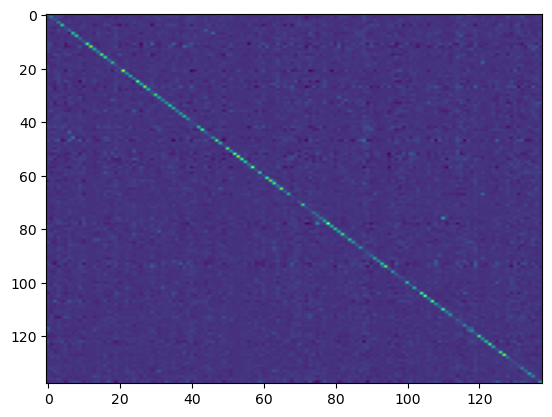

In [86]:
import matplotlib as mpl
import matplotlib.pyplot as plt


plt.imshow(Weights, aspect='auto')
#plt.plot(np.mean(Inputs[0], axis = 0))